This notebook showcases plotting data from the Statistics Finland PAAVO data set.

In [21]:
from itertools import chain
import pandas as pd
import data_transforms
import from_r_gen
import viz
import similarity
import map_fi_plot
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.chdir('/Users/tjpajala/PycharmProjects/paavo')
os.getcwd()
from ipywidgets import interact
import ipywidgets as widgets
%matplotlib notebook

In [22]:

data = from_r_gen.load_r_data('paavo_counts.csv')
data2 = from_r_gen.load_r_data('paavo_shares.csv')

data = data_transforms.merge_and_clean_data(data, data2)

#save aggregated to different df
data_agg = data.loc[data["pono.level"] != 5, :]
data = data.loc[data['pono.level'] == 5, :]

for column_to_impute in data.columns.values:
    if column_to_impute not in ['pono', 'pono.level', 'vuosi', 'nimi']:
        data.loc[data[column_to_impute].isnull(), column_to_impute] = data_transforms.\
            impute_with_class_mean(data, column_to_impute)


#select only one year
data = data.loc[data['vuosi'] == 2018, :]

#select only individual postcode areas
data = data.loc[data['pono.level'] == 5, :]

/Users/tjpajala/miniconda3/envs/some_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (11,40,41,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/tjpajala/miniconda3/envs/some_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (9,18,19,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/tjpajala/miniconda3/envs/some_env/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [23]:
X, y, target_names = viz.get_pca_data(data, 2018, 5)
target_names.index = range(len(target_names))
X_pca, pipe = viz.do_pca(X, 5)
d = similarity.pairwise_distances(X_pca, X_pca, 'euclidean')
print(target_names.shape)
print(X_pca.shape)

(3030,)
(3030, 5)


Ok, data has been loaded.

In [24]:
def get_similar_in_table(data, orig_name, comparison_names, target_names, X_pca, cols):
    return viz.table_similar_with_names(data, orig_name, comparison_names, target_names, X_pca, cols=None)


def get_data_interactive(data, postcode):
    cols = ['pono','nimi']+data_transforms.NOMINAL_VARS+data_transforms.SHARES_VARS
    if postcode != '':
        return data.loc[data['pono'].str.contains(postcode), cols].sort_values('pono')

s=[('','')]+[(str(data.iloc[i,:]['pono']+' '+data.iloc[i,:]['nimi']), data.iloc[i,:]['nimi']) for i in range(len(data))]



In [25]:
from IPython.display import display, clear_output

def get_map_plot(data, postcode):
    area_name = data.loc[data['pono']==postcode, 'nimi'].tolist()[0]
    print(area_name)
    if area_name != '':
        highlights = similarity.get_n_most_similar_with_name(area_name,d,target_names,15)
        map_fi_plot.map_with_highlights_names(data, "Most similar to {}".format(area_name), origin_name=area_name, 
                                          highlights=highlights, figsize=(12,10))

def render_elements(data, postcode):
    area_name = data.loc[data['pono'] == postcode, 'nimi'].tolist()[0]
    highlights = similarity.get_n_most_similar_with_name(area_name, d, target_names, 15)
    all_names = highlights.tolist()
    all_names.append(area_name)
    all_postcodes=data.loc[data['nimi'].isin(all_names), 'pono']
    with out:
        display(get_map_plot(data, field.value))
    out.clear_output(wait=True)
    with out_table:
        display(get_similar_in_table(data, area_name, highlights,target_names, X_pca, cols=None))
    out_table.clear_output(wait=True)


def on_button_click(sender):
    render_elements(data, field.value)
    

def on_field_submit(sender):
    render_elements(data, field.value)


#interact(lambda postcode: get_data_interactive(data, postcode), postcode='')
#interact(lambda postcode: get_table_and_plot(data, postcode), postcode='')
field = widgets.Text(description="postinumero")
field.on_submit(on_field_submit)
button = widgets.Button(description='Laske')
out_table = widgets.Output(layout={'border': '1px solid black'})
out = widgets.Output(layout={'border': '1px solid black'})
out_pca = widgets.Output(layout={'border': '1px solid black'})
button.on_click(on_button_click)
display(field)
display(button)
widgets.VBox([out_table, out])

Text(value='', description='postinumero')

Button(description='Laske', style=ButtonStyle())

We can also analyze areas according to geographical region. The implemented function can either present results inside a certain region around a target (method='intersection') or outside the defined sphere (method='difference'). These reprepresent the use cases of moving close to a certain target, or "anywhere besides here", respectively.

<IPython.core.display.Javascript object>


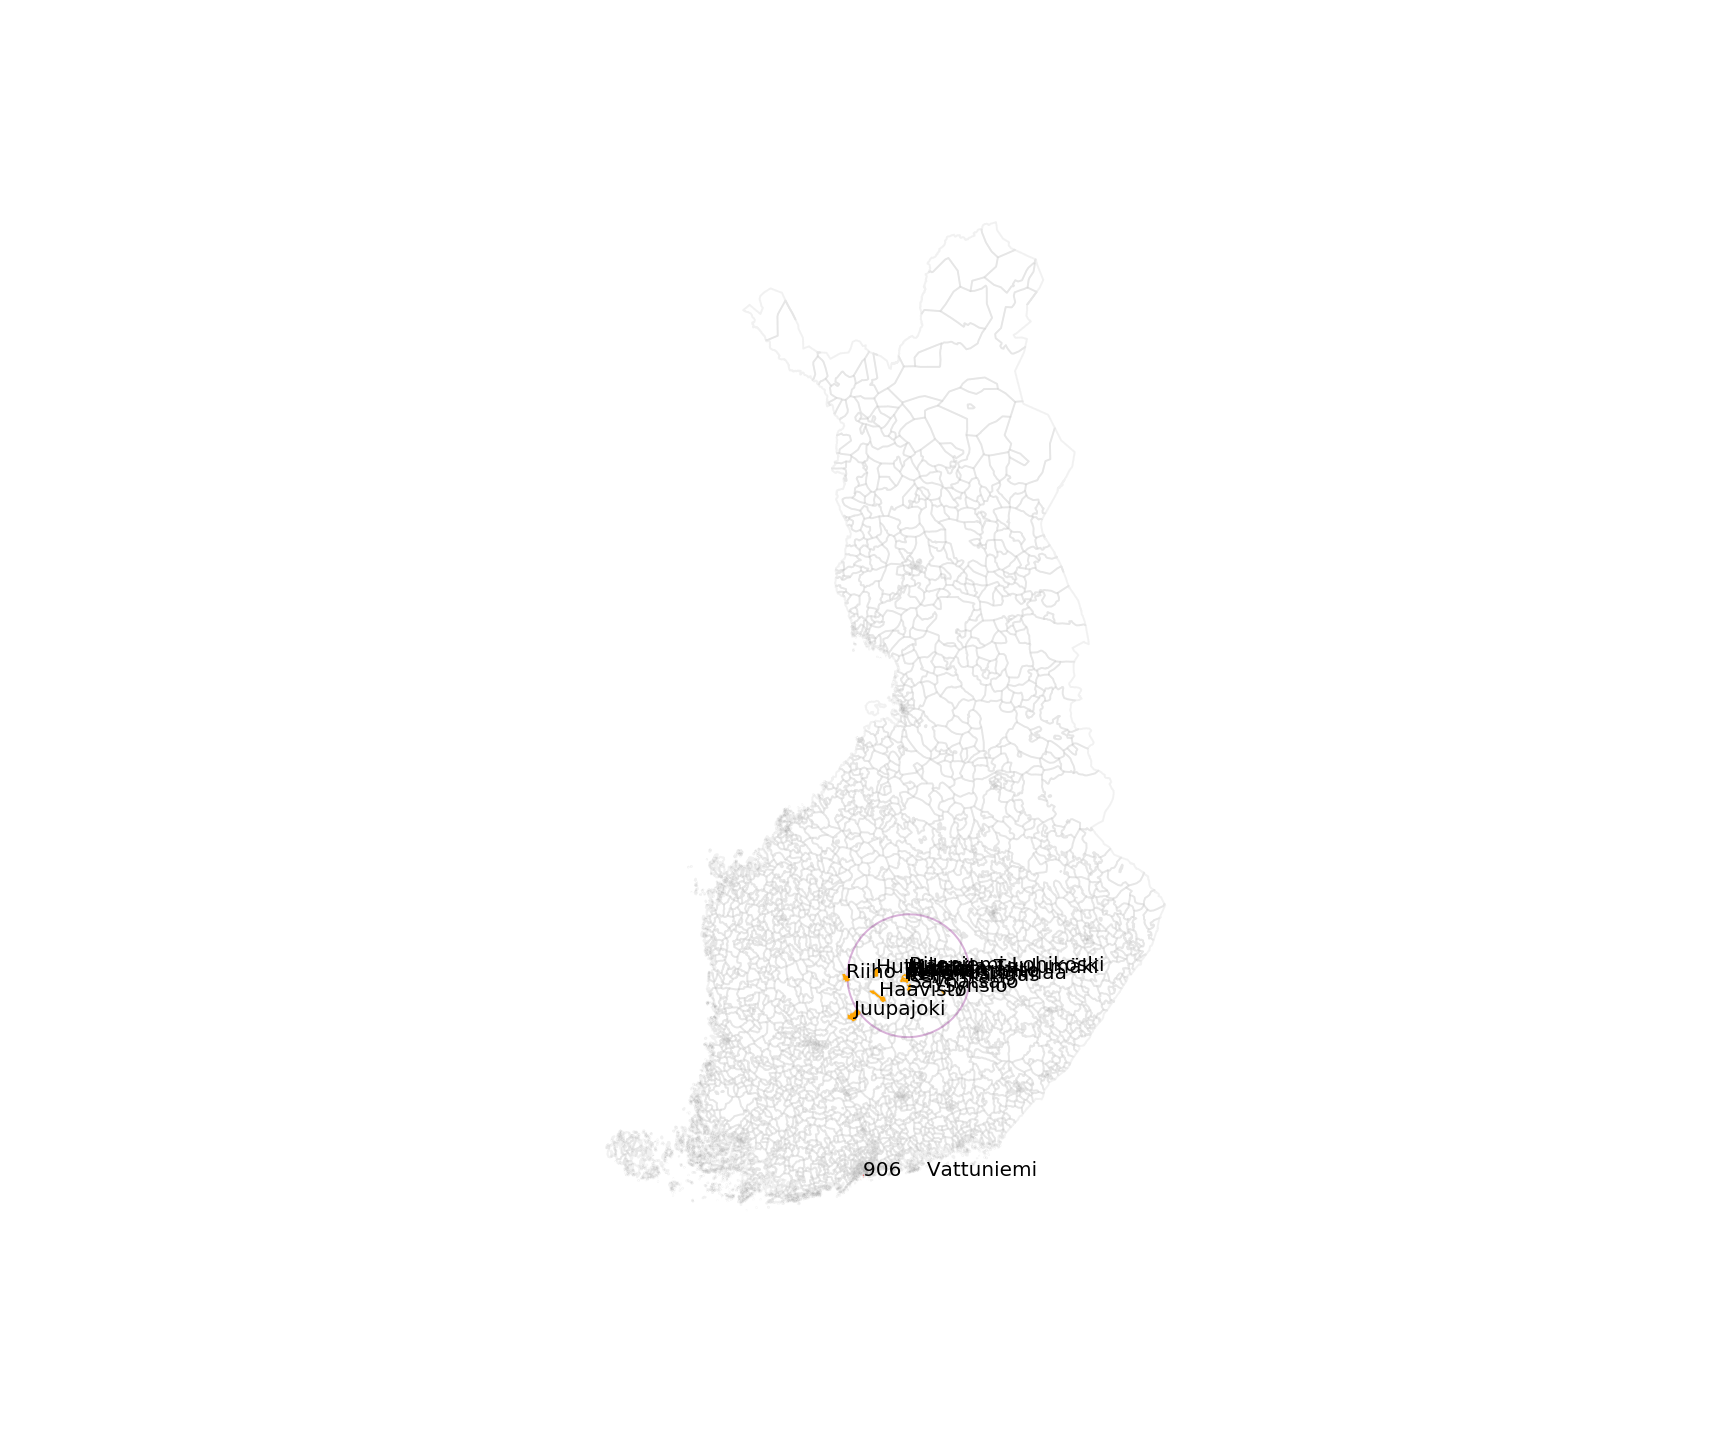

In [26]:

map_fi_plot.plot_similar_in_geo_area(data, orig_name='Vattuniemi', target='Jyväskylä Keskus', range_km=70,
                                     how='intersection', n_most=15, pipe=pipe, figsize=(12, 10))

The requested areas similar to Vattuniemi are clustered around Jyväskylä, as they should be. 

<IPython.core.display.Javascript object>


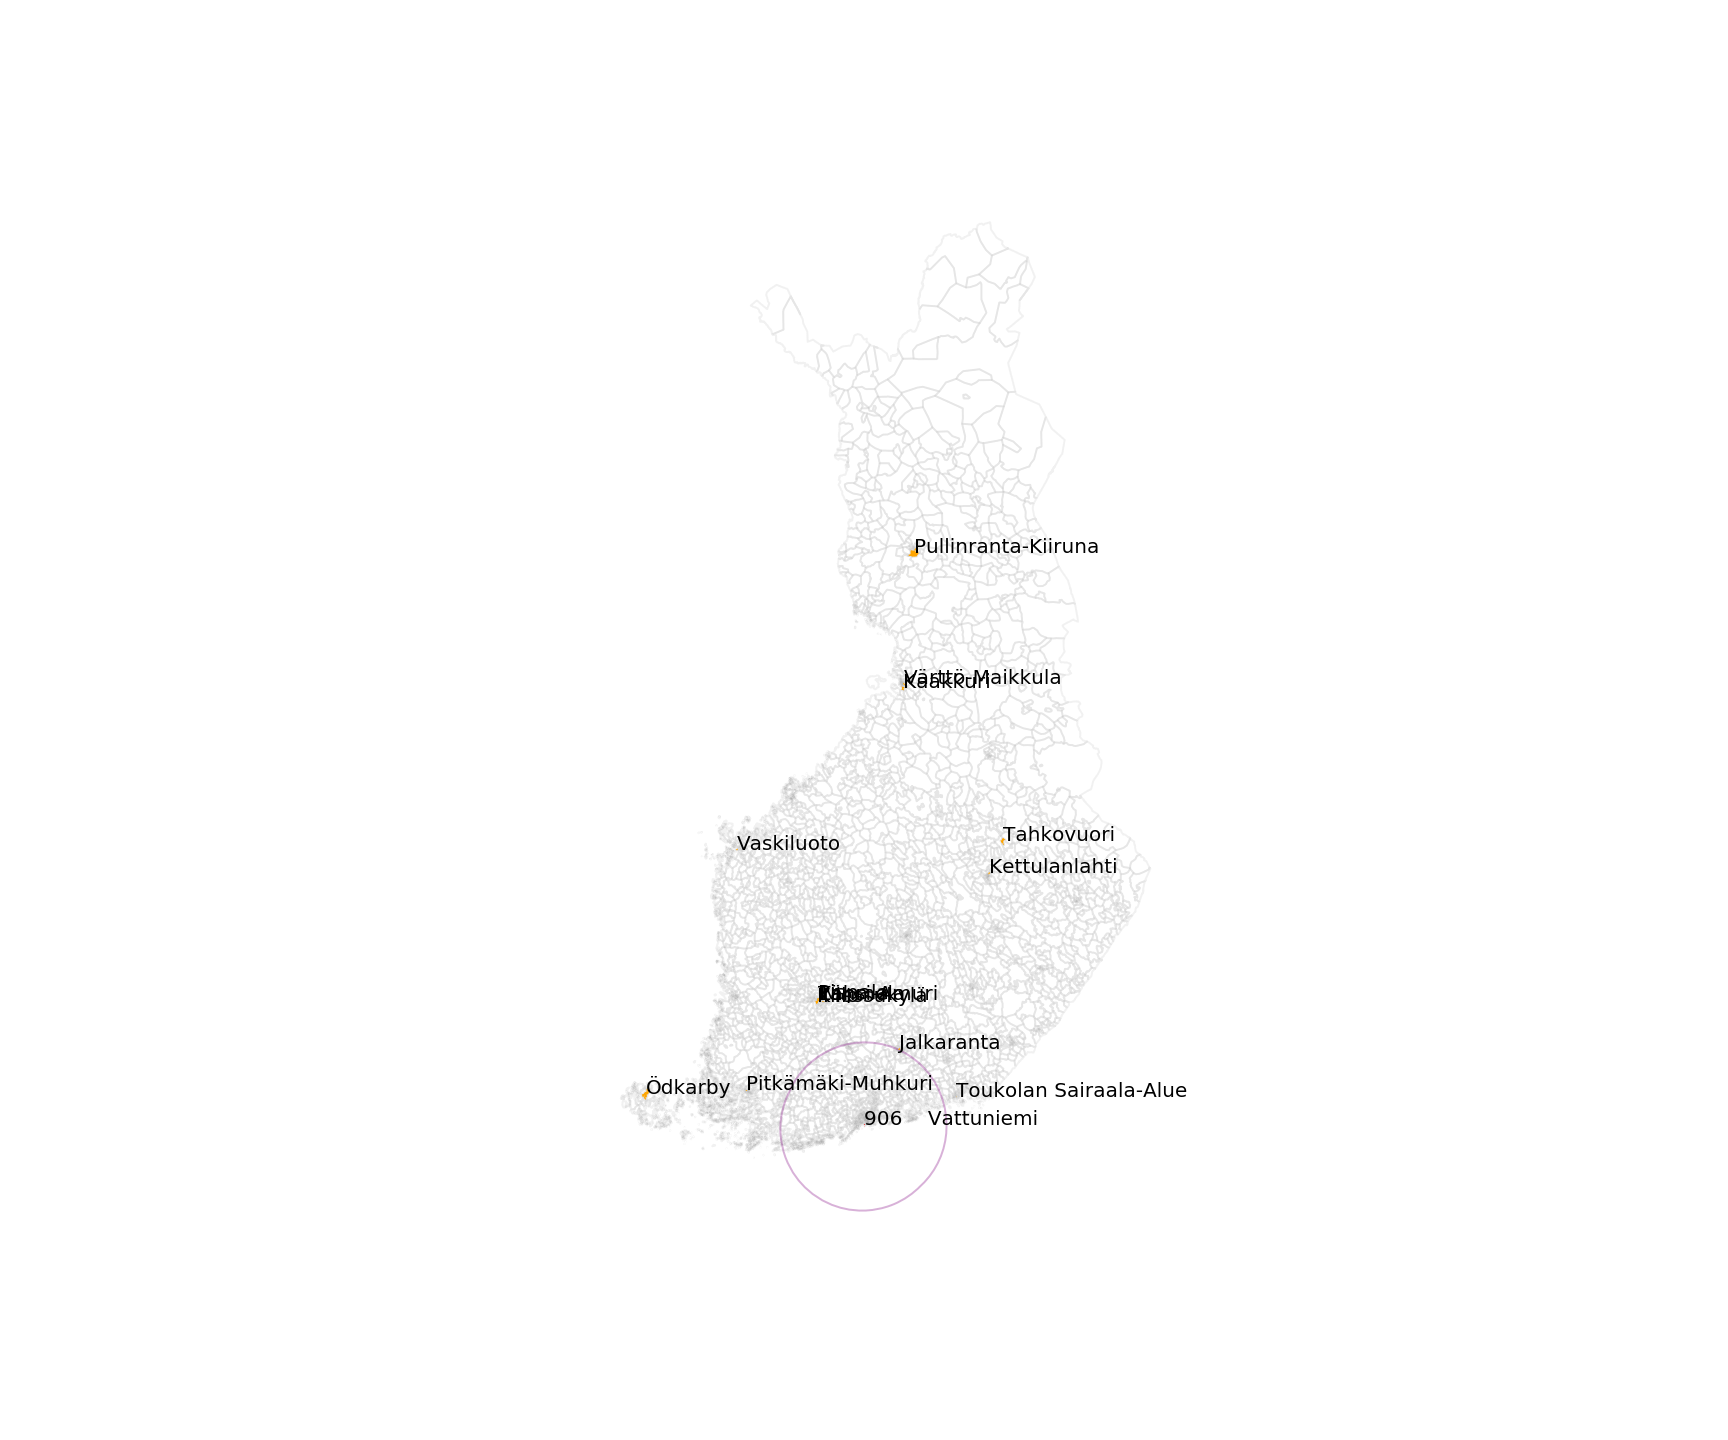

In [27]:
map_fi_plot.plot_similar_in_geo_area(data, orig_name='Vattuniemi', target='Vattuniemi', range_km=100,
                                     how='difference', n_most=15, pipe=pipe, figsize=(12, 10))

Getting areas at least 100 km away from Vattuniemi spread the alternatives more across Finland. This suggests (as expected) that similar areas are not just clustered around Jyväskylä - indeed, they seem to be more in the western regions.

Finally, as a sort of sanity check, we can plot similar areas to Vattuniemi with two selections. Once with a region selection of within 100km of Vattuniemi, and once with a selection of anywhere at least 100 km from Turku. Assuming our algorithm works, we should get the same results for both, the only difference being the placement of the circle.

<IPython.core.display.Javascript object>


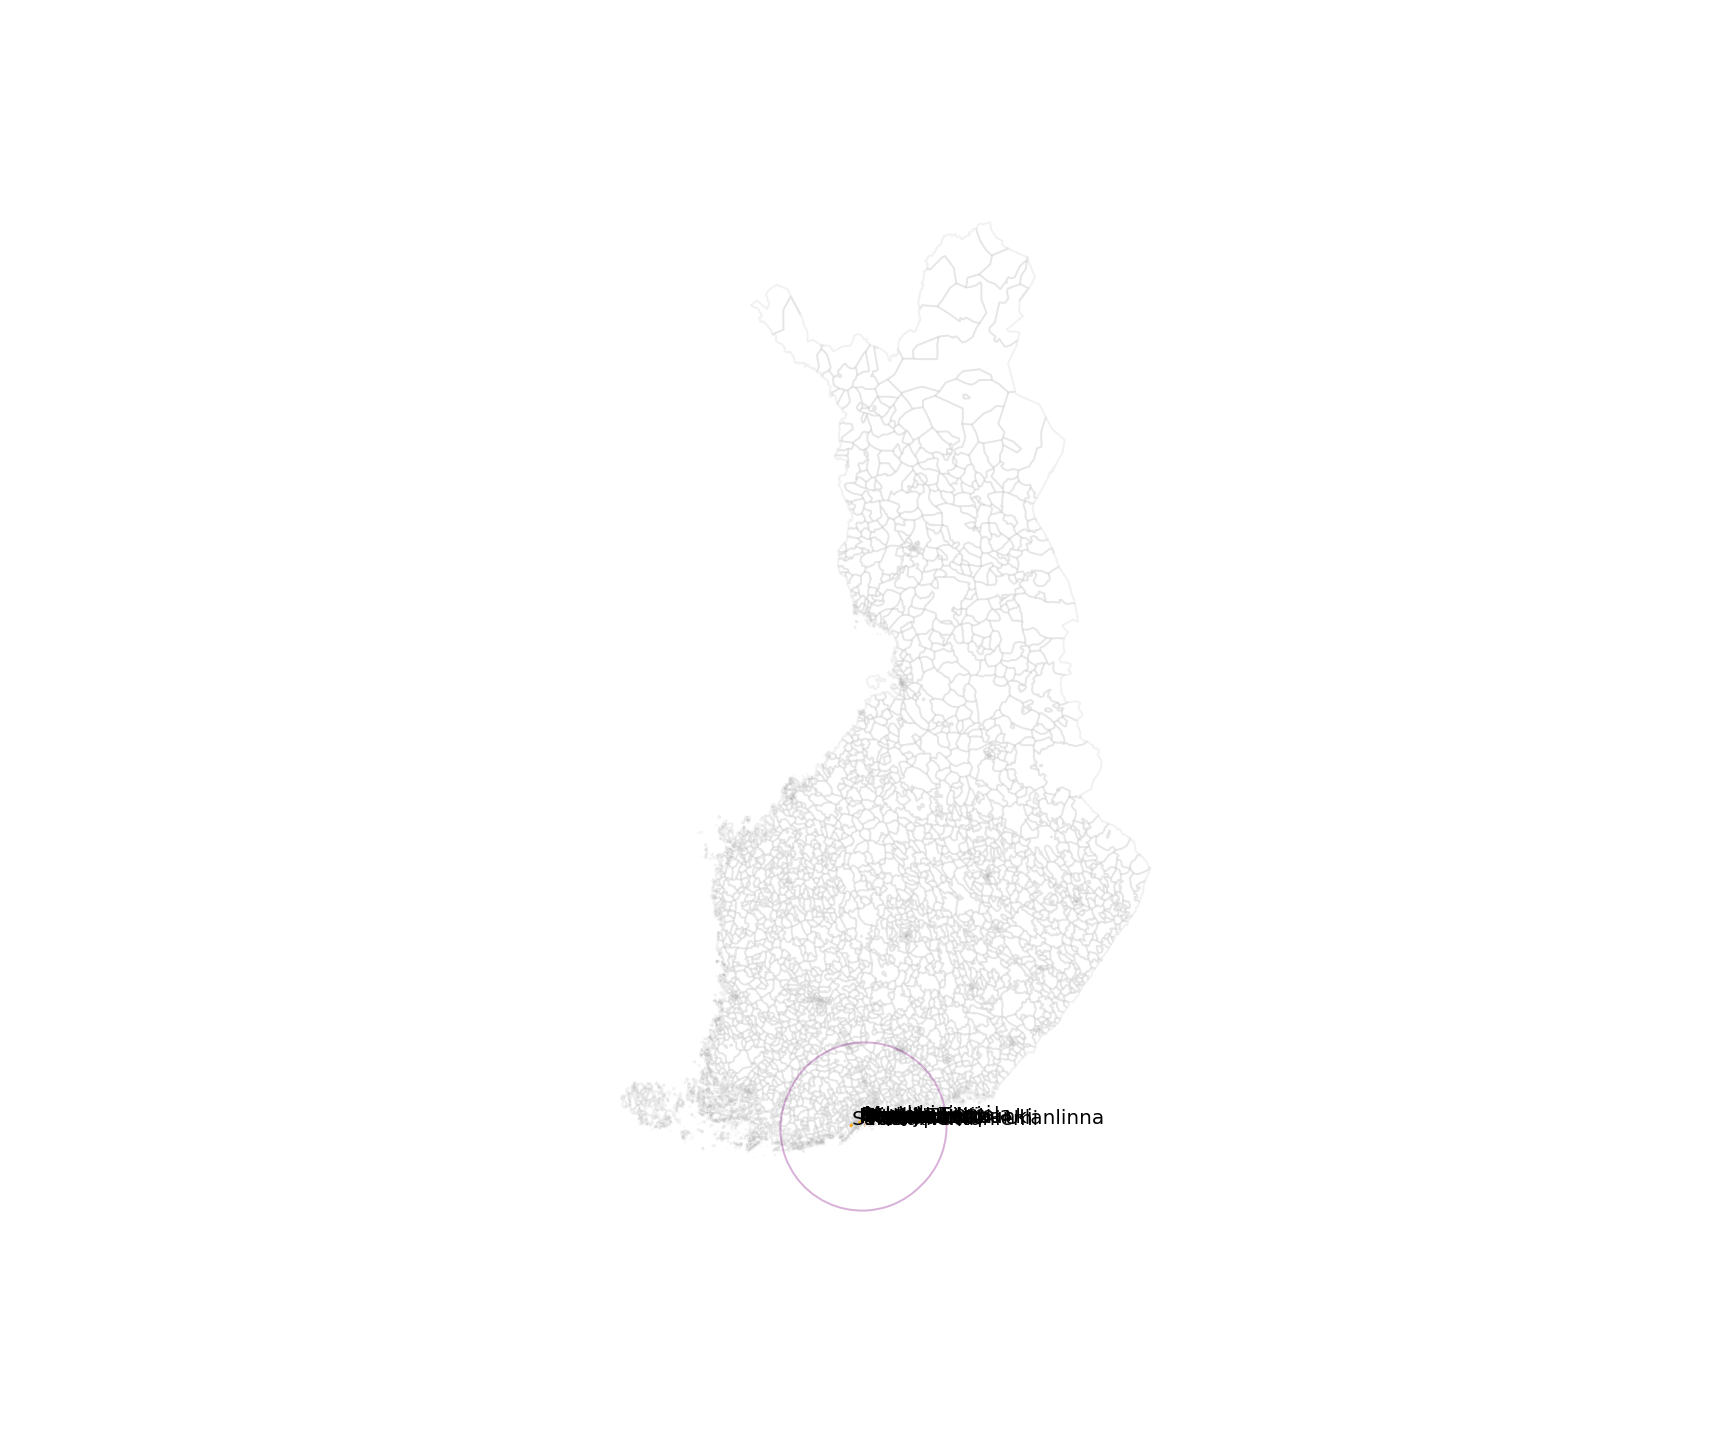

In [28]:
map_fi_plot.plot_similar_in_geo_area(data, orig_name='Vattuniemi', target='Vattuniemi', range_km=100,
                                     how='intersection', n_most=15, pipe=pipe, figsize=(12, 10))

<IPython.core.display.Javascript object>


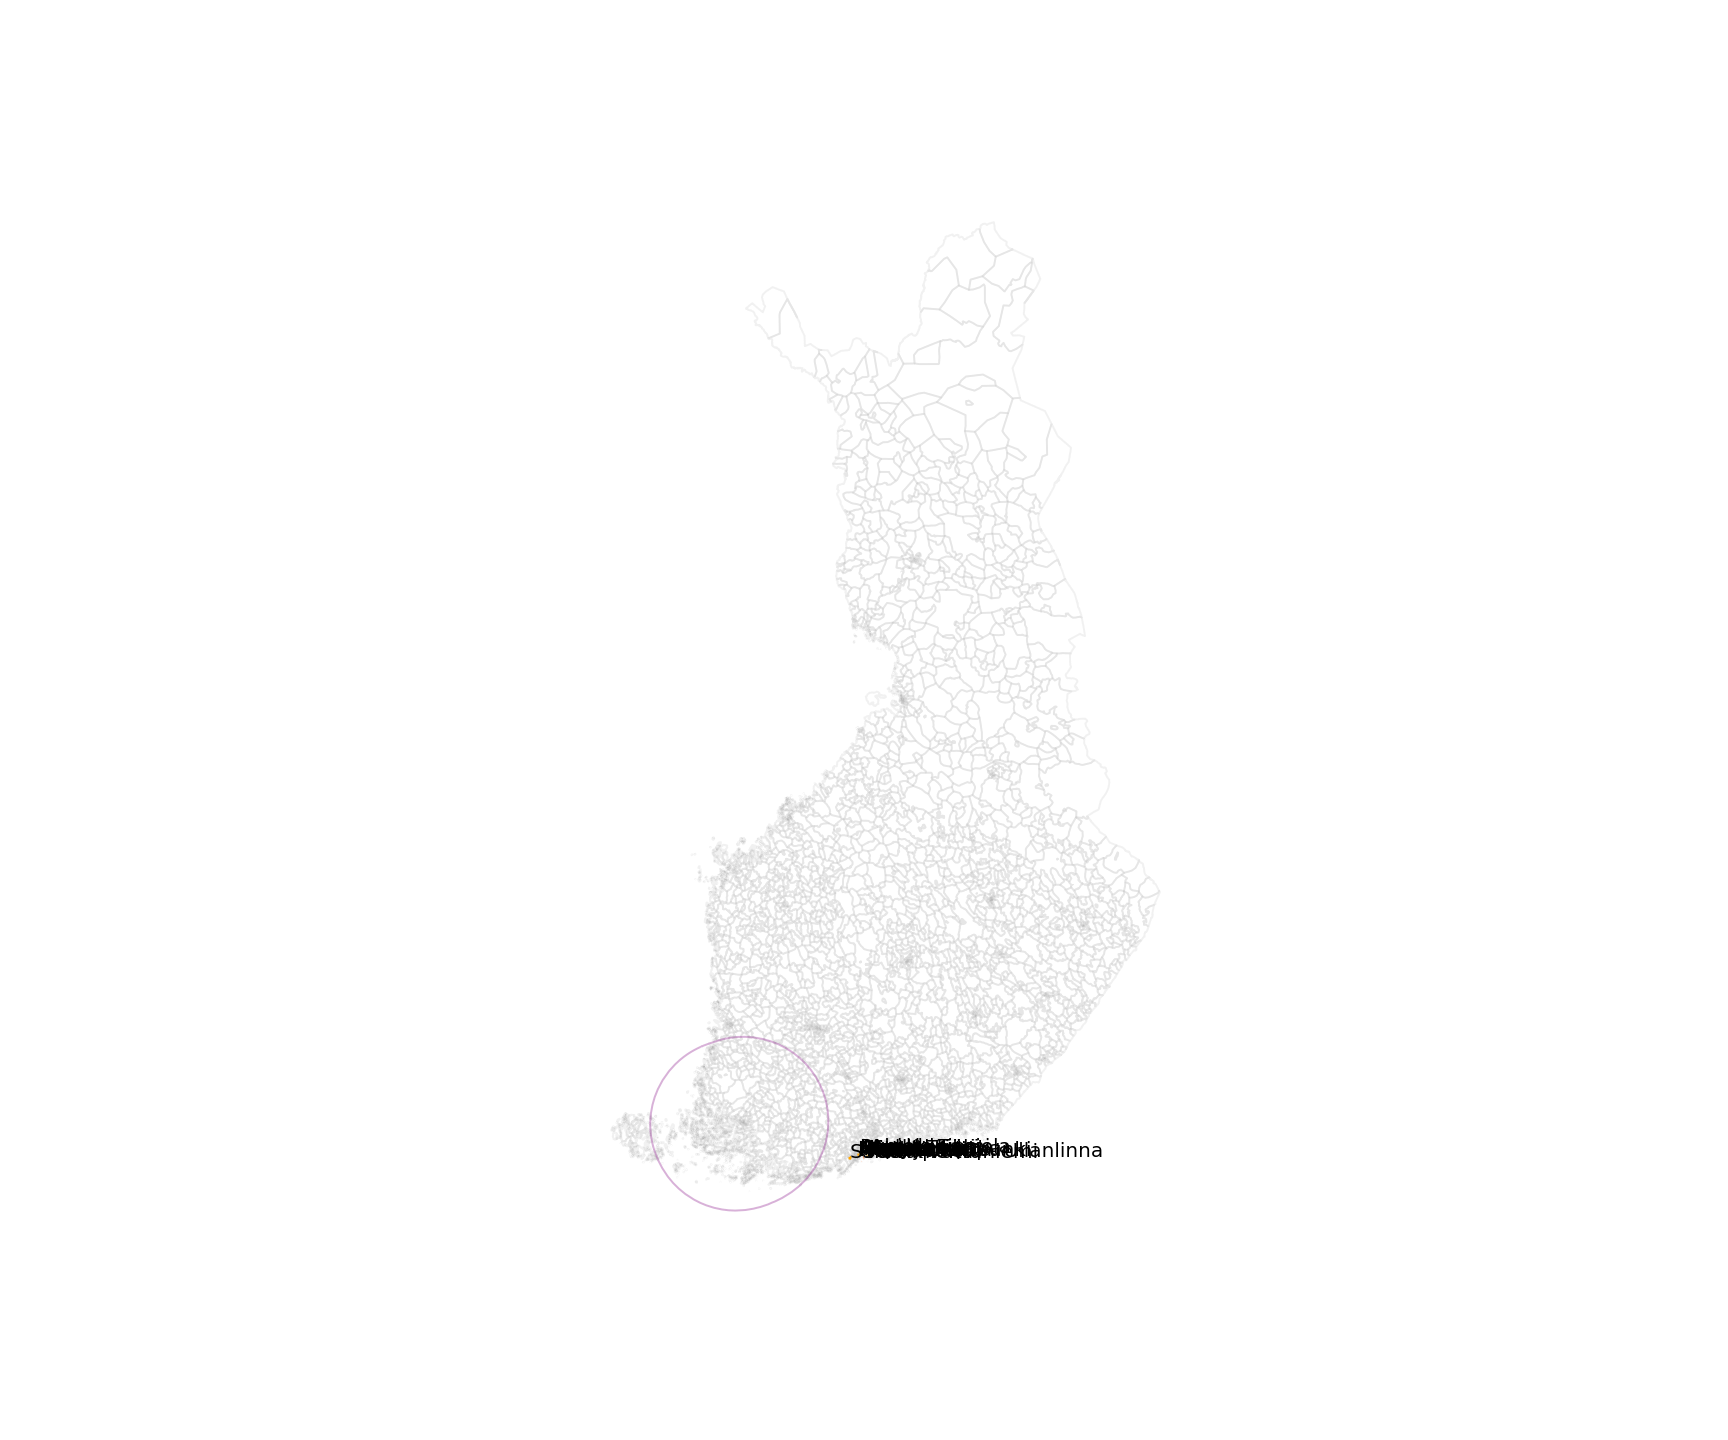

In [29]:
map_fi_plot.plot_similar_in_geo_area(data, orig_name='Vattuniemi', target='Turku Keskus', range_km=100,
                                     how='difference', n_most=15, pipe=pipe, figsize=(12, 10))

Yep, we get the same results as expected!

Now, an interesting way of looking at the results is to plot them on the map of postcodes. We will classify each area according to the factor that has the highest load, and plot this variable on the map. If our PCA is good at compressing differences between cities and the countryside into the loadings, this should be visible on the map.

<IPython.core.display.Javascript object>


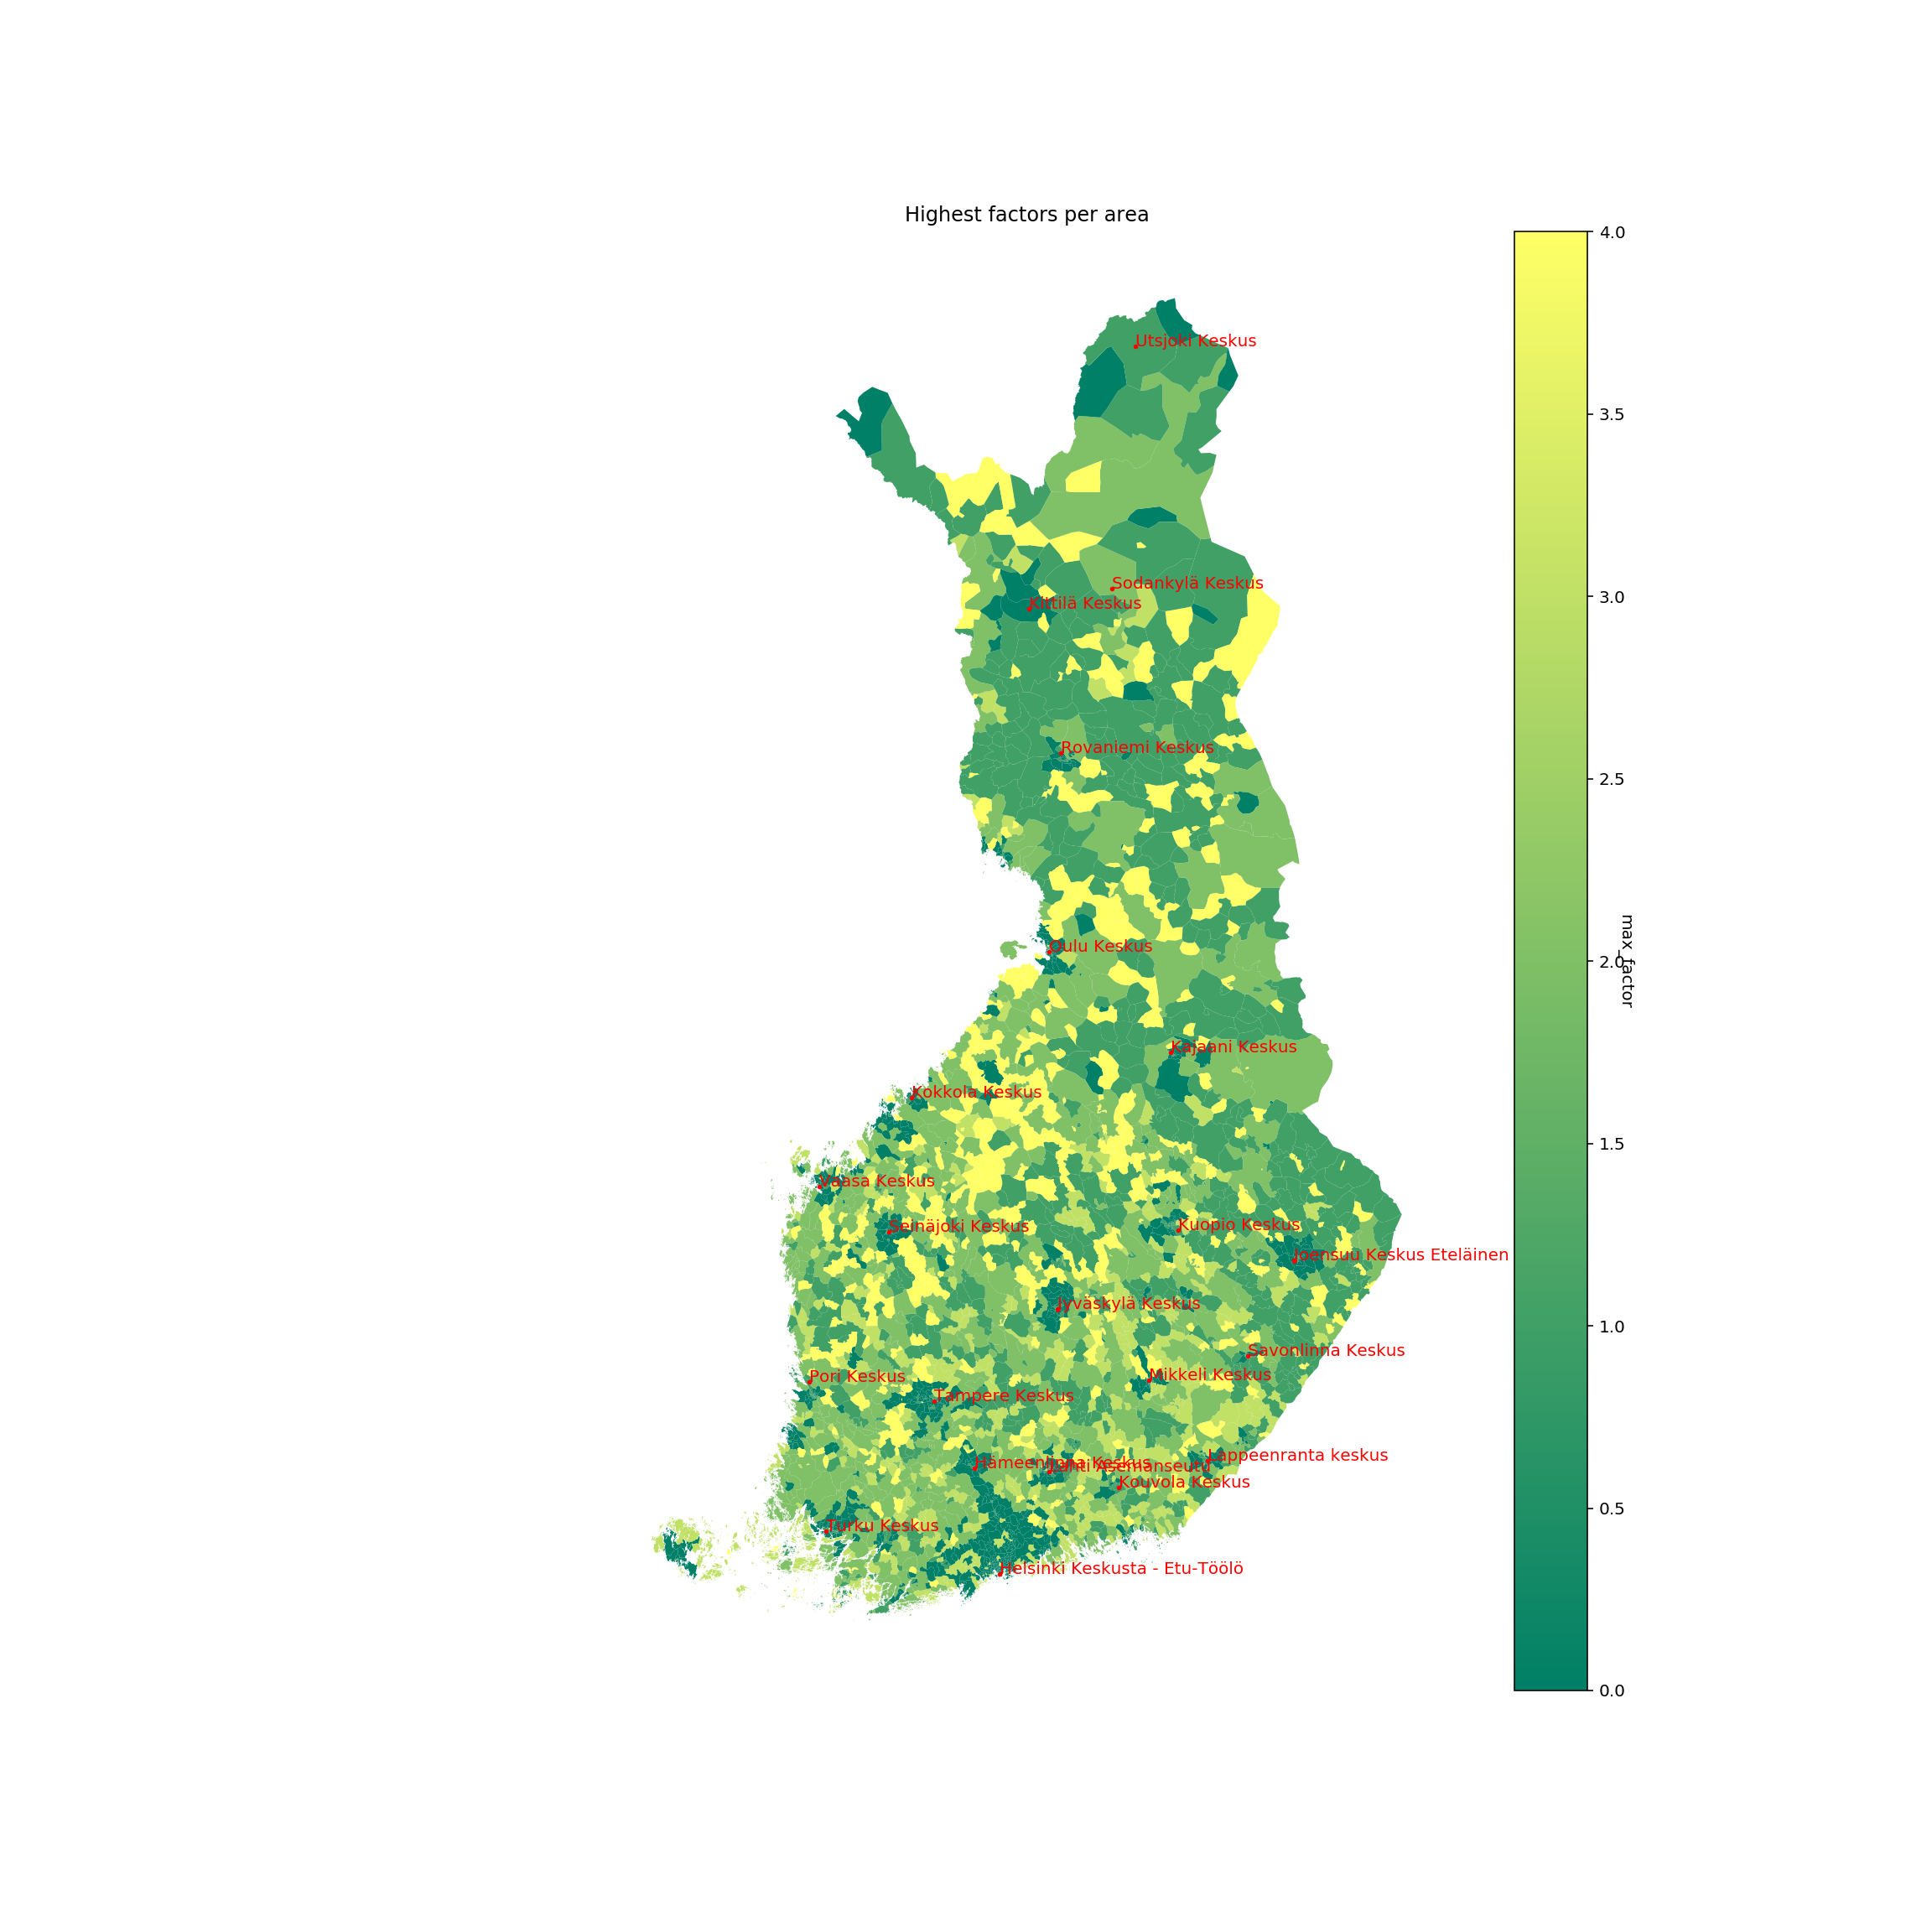

In [30]:
X_pca, pipe = viz.do_pca(X, 5)
data_l5 = data.loc[data['pono.level'] == 5, :].assign(max_factor=pd.DataFrame(X_pca.argmax(axis=1)))
map_fi_plot.map_fi_postinumero(data_l5, "Highest factors per area", color_var='max_factor')